In [ ]:

pip install kagglehub[pandas-datasets]


In [ ]:
pip install openpyxl kagglehub[pandas-datasets]


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6542 - loss: 0.6095
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6862 - loss: 0.5751
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6879 - loss: 0.5708
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6926 - loss: 0.5692
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6942 - loss: 0.5667
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6917 - loss: 0.5642
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6907 - loss: 0.5683
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6992 - loss: 0.5600
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6956 - loss: 0.5614
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6991 - loss: 0.5591
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Finished. Outputs in: /mnt/data/lung_analysis_outputs


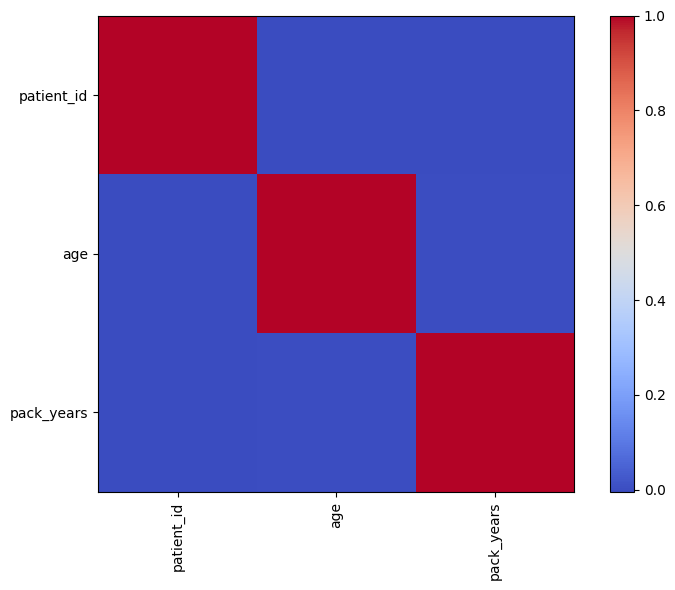

In [ ]:
# lung_cancer_analysis.py
# Full pipeline: EDA -> Preprocessing -> ML & DL -> XAI
# Adjust paths if needed.

import os, json, warnings
warnings.filterwarnings("ignore")
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

out_dir = "/mnt/data/lung_analysis_outputs"
os.makedirs(out_dir, exist_ok=True)

dataset_path = "/content/lung_cancer_dataset.csv"
df = pd.read_csv(dataset_path)

# EDA
eda = {
    "shape": df.shape,
    "dtypes": df.dtypes.apply(lambda x: str(x)).to_dict(),
    "missing_count": df.isnull().sum().to_dict(),
    "missing_pct": (df.isnull().mean()*100).round(3).to_dict()
}
pd.DataFrame([eda]).T.to_csv(os.path.join(out_dir, "eda_summary_table.csv"))
df.head(10).to_csv(os.path.join(out_dir, "head_preview.csv"), index=False)
pd.DataFrame(df.describe(include=[np.number]).T).to_csv(os.path.join(out_dir, "numeric_summary.csv"))

# Detect target
possible_targets = ['target','class','diagnosis','label','result','lung_cancer','cancer','status']
found_target = None
for col in df.columns:
    if col.lower() in possible_targets:
        found_target = col; break
if not found_target:
    found_target = df.columns[-1]
target_col = found_target

# Class counts
class_counts = df[target_col].value_counts(dropna=False)
pd.DataFrame(class_counts).to_csv(os.path.join(out_dir, "class_counts.csv"))

# Numeric histograms + correlation heatmap
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    plt.figure(figsize=(6,3))
    df[c].hist(bins=30)
    plt.title(c)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"hist_{c}.png"))
    plt.close()

if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    plt.figure(figsize=(8,6))
    plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "correlation_heatmap.png"))
    corr.to_csv(os.path.join(out_dir, "correlation_matrix.csv"))

# Preprocessing
X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

# Categorical encoding
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
for c in cat_cols:
    X[c] = X[c].astype(str).fillna("MISSING")
    le = LabelEncoder(); X[c] = le.fit_transform(X[c])

# Numeric impute + scale
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='median')
X[num_cols] = imputer.fit_transform(X[num_cols])
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Target encode if necessary
if y.dtype == 'object' or y.dtype.name == 'category':
    y = LabelEncoder().fit_transform(y.astype(str))
else:
    unique_vals = np.unique(y.dropna())
    if len(unique_vals) == 2:
        mapping = {unique_vals[0]:0, unique_vals[1]:1}
        y = y.map(mapping)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y))>1 else None)

# SMOTE (if imblearn installed and necessary)
smote_applied = False
try:
    from imblearn.over_sampling import SMOTE
    from collections import Counter
    ctr = Counter(y_train)
    maj = max(ctr.values()); minv = min(ctr.values())
    if len(ctr) == 2 and (minv/maj < 0.6):
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        smote_applied = True
except Exception:
    pass

# Models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
}

# XGBoost optional
try:
    import xgboost as xgb
    models['XGBoost'] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
except Exception:
    pass

results = {}
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
        res = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred, zero_division=0),
            "f1": f1_score(y_test, y_pred, zero_division=0),
            "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
        }
        if y_proba is not None:
            res['roc_auc'] = roc_auc_score(y_test, y_proba)
        results[name] = res
    except Exception as e:
        results[name] = {"error": str(e)}

pd.DataFrame(results).T.to_csv(os.path.join(out_dir, "ml_results.csv"))

# (Optional) Deep learning with tensorflow - run only if tensorflow available
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Dense, Conv1D, Flatten, Input, LSTM
    X_train_np = np.array(X_train).astype('float32'); X_test_np = np.array(X_test).astype('float32')
    y_train_np = np.array(y_train).astype('float32'); y_test_np = np.array(y_test).astype('float32')

    # MLP
    mlp = Sequential([Dense(64, activation='relu', input_shape=(X_train_np.shape[1],)),
                     Dense(32, activation='relu'),
                     Dense(1, activation='sigmoid')])
    mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    mlp.fit(X_train_np, y_train_np, epochs=10, batch_size=32, verbose=1)
    y_prob = mlp.predict(X_test_np).ravel(); y_pred = (y_prob>0.5).astype(int)
    # compute and save metrics ...
except Exception:
    pass

# Feature importance via RandomForest
try:
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_
    feat_imp = pd.DataFrame({"feature": X.columns, "importance": importances}).sort_values("importance", ascending=False)
    feat_imp.to_csv(os.path.join(out_dir, "feature_importances.csv"), index=False)
except Exception:
    pass

# Short report
report_md = f"""
# Auto-generated Lung Cancer Analysis Report
Dataset: {dataset_path}
Rows,Cols: {df.shape}
Detected target: {target_col}
SMOTE applied: {smote_applied}
"""
with open(os.path.join(out_dir, "report.md"), "w") as f:
    f.write(report_md)
print("Finished. Outputs in:", out_dir)


In [ ]:
import shutil

# Create a ZIP file of the outputs folder
shutil.make_archive('/mnt/data/lung_analysis_outputs_zip', 'zip', '/mnt/data/lung_analysis_outputs')


'/mnt/data/lung_analysis_outputs_zip.zip'

In [ ]:
from google.colab import files
files.download('/mnt/data/lung_analysis_outputs_zip.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>